In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/test.csv


# Import Libraries

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

Check & State Data Types

# Load Data

In [3]:
train = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/train.csv')
test = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/test.csv')

# Identify Data Types

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                90000 non-null  int64  
 1   customer_id       90000 non-null  int64  
 2   last_name         90000 non-null  object 
 3   credit_score      80444 non-null  float64
 4   country           83979 non-null  object 
 5   gender            90000 non-null  object 
 6   age               90000 non-null  float64
 7   tenure            90000 non-null  int64  
 8   acc_balance       82743 non-null  float64
 9   prod_count        85137 non-null  float64
 10  has_card          90000 non-null  float64
 11  is_active         90000 non-null  float64
 12  estimated_salary  90000 non-null  float64
 13  exit_status       90000 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 9.6+ MB


#  Descriptive Statistics

In [5]:
train.describe()

,id,customer_id,credit_score,age,tenure,acc_balance,prod_count,has_card,is_active,estimated_salary,exit_status
count,90000.000000,9.000000e+04,80444.000000,90000.000000,90000.000000,82743.000000,85137.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,44999.500000,1.569209e+07,656.497054,38.119533,5.017022,55456.732147,1.552932,0.754289,0.497178,112394.659679,0.211600
std,25980.906451,7.129796e+04,80.016856,8.855203,2.804813,62788.474236,0.548011,0.430510,0.499995,50360.440702,0.408445
min,0.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,22499.750000,1.563361e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74430.360000,0.000000
50%,44999.500000,1.569016e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117505.070000,0.000000
75%,67499.250000,1.575674e+07,710.000000,42.000000,7.000000,119825.750000,2.000000,1.000000,1.000000,154874.787500,0.000000
max,89999.000000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


# Check Missing Values

In [6]:
train.isnull().sum()

id                     0
customer_id            0
last_name              0
credit_score        9556
country             6021
gender                 0
age                    0
tenure                 0
acc_balance         7257
prod_count          4863
has_card               0
is_active              0
estimated_salary       0
exit_status            0
dtype: int64

# Handle Missing Values 

In [7]:
train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,customer_id,last_name,credit_score,country,gender,age,tenure,acc_balance,prod_count,has_card,is_active,estimated_salary,exit_status
0,0,15788291,Iredale,559.0,France,Male,28.0,1,149989.39,1.0,1.0,1.0,67622.46,0
1,1,15642816,Hs?,694.0,France,Female,37.0,7,114510.35,2.0,0.0,0.0,182797.86,0
2,2,15632272,T'ien,585.0,NaN,Female,45.0,8,NaN,2.0,1.0,1.0,170338.35,0
3,3,15685826,Hightower,589.0,Spain,Male,25.0,0,166082.18,1.0,1.0,1.0,166476.46,0
4,4,15658032,Hopkins,701.0,France,Male,39.0,2,0.00,2.0,1.0,0.0,82526.92,0


In [8]:
train.drop(['id','last_name'], axis=1, inplace=True)
test_ids = test['customer_id']
test.drop(['id', 'last_name', 'customer_id'], axis=1, inplace=True)


In [9]:
train['country'] = train['country'].fillna(train['country'].mode()[0])
test['country'] = test['country'].fillna(test['country'].mode()[0])

In [10]:
numeric_cols_train = train.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_test = test.select_dtypes(include=['float64', 'int64']).columns
common_numeric_cols = list(set(numeric_cols_train).intersection(set(numeric_cols_test)))

In [11]:
for col in common_numeric_cols:
    if train[col].isnull().sum() > 0:
        train[col] = train[col].fillna(train[col].median())
    if test[col].isnull().sum() > 0:
        test[col] = test[col].fillna(train[col].median())

# Handle Duplicates

In [12]:
train.drop_duplicates(inplace=True)

# Identify and handle outliers 

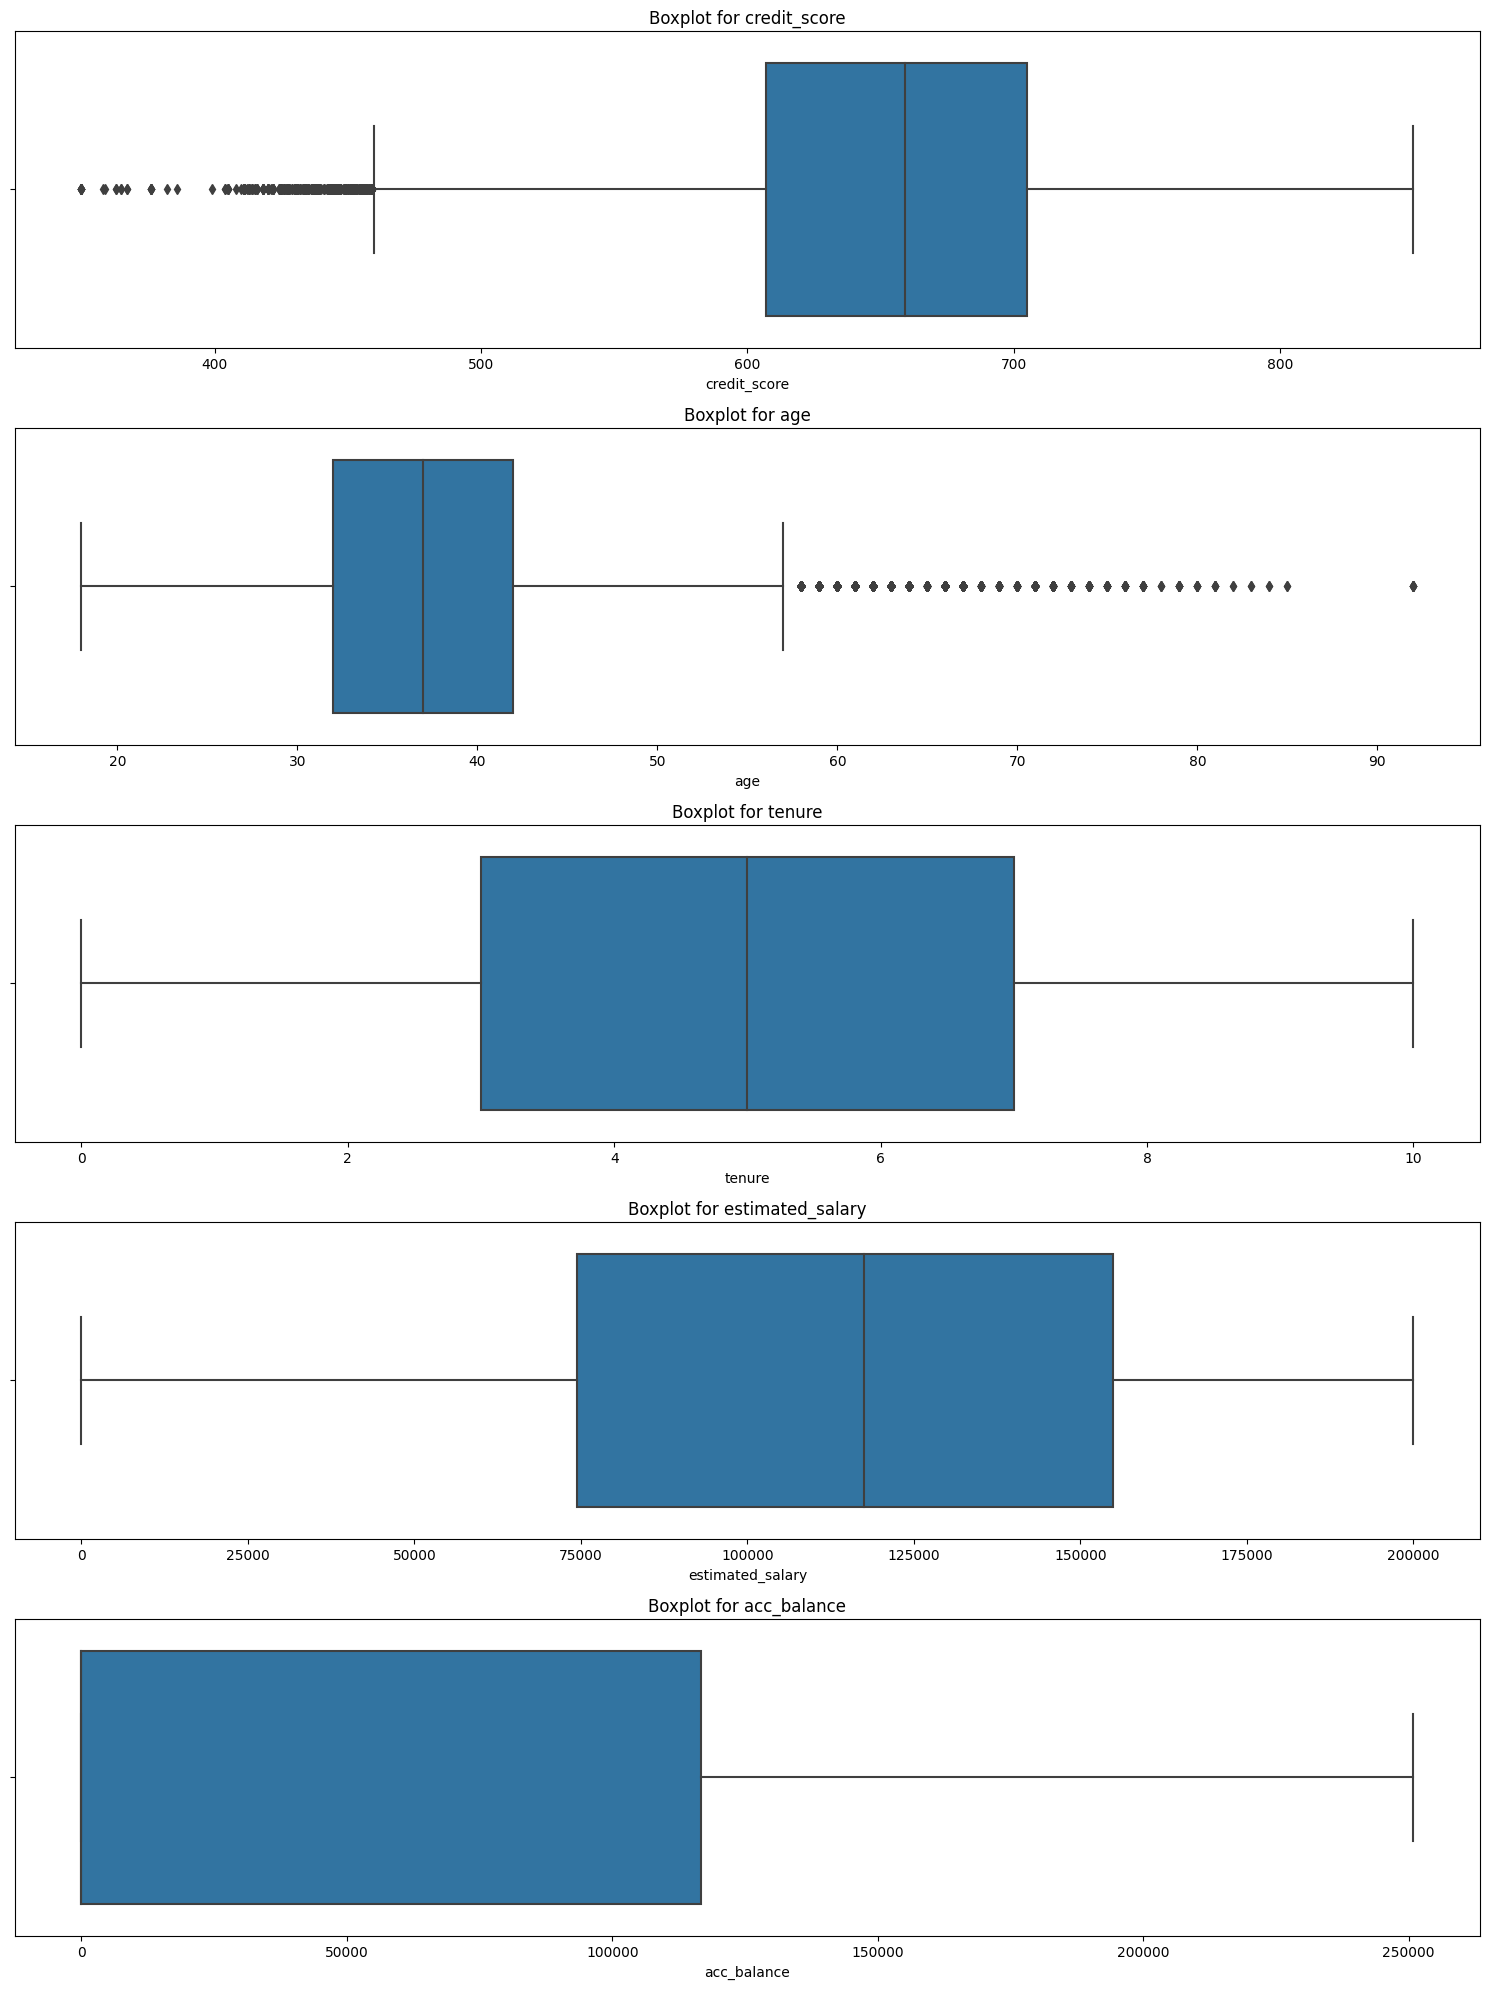

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['credit_score','age','tenure','estimated_salary','acc_balance']

plt.figure(figsize=(15, 20))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot for {col}')
plt.tight_layout()
plt.show()

# Visulization

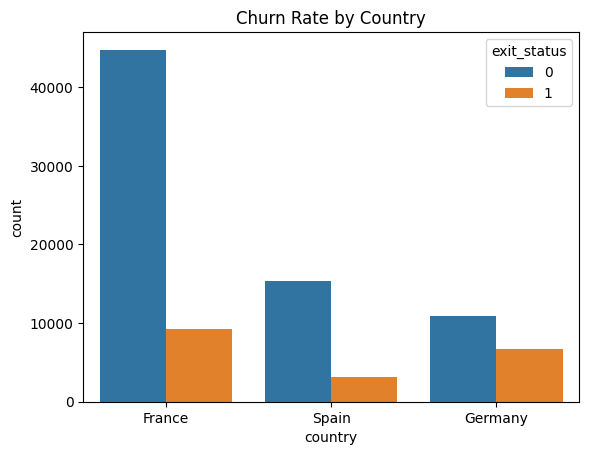

In [14]:
# Exit rate by country
sns.countplot(x='country', hue='exit_status', data=train)
plt.title('Churn Rate by Country')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


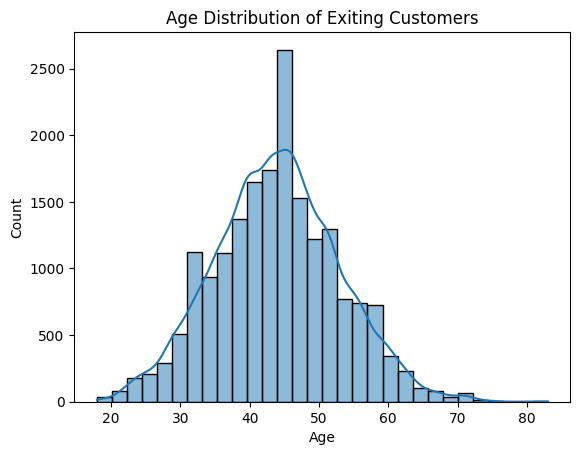

In [15]:
# Age distribution for churned customers
sns.histplot(train[train['exit_status'] == 1]['age'], bins=30, kde=True)
plt.title("Age Distribution of Exiting Customers")
plt.xlabel("Age")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


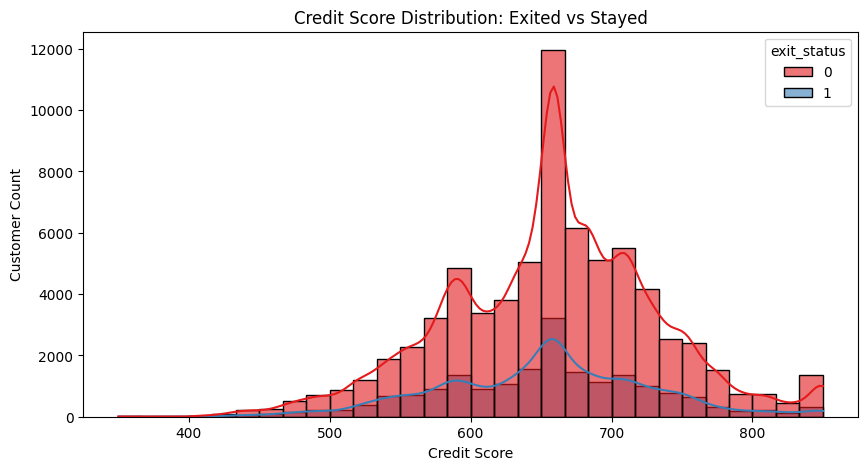

In [16]:
#Credit Score by Exit Status
plt.figure(figsize=(10, 5))
sns.histplot(data=train, x='credit_score', hue='exit_status', bins=30, kde=True, palette='Set1', alpha=0.6)
plt.title("Credit Score Distribution: Exited vs Stayed")
plt.xlabel("Credit Score")
plt.ylabel("Customer Count")
plt.show()

# ENCODING CATEGORICAL VARIABLES

In [17]:
le_gender = LabelEncoder()
le_country = LabelEncoder()

train['gender'] = le_gender.fit_transform(train['gender'])
test['gender'] = le_gender.transform(test['gender'])

train['country'] = le_country.fit_transform(train['country'])
test['country'] = le_country.transform(test['country'])

# SCALING NUMERICAL FEATURES

In [18]:
scaler = StandardScaler()
X = train.drop(['exit_status', 'customer_id'], axis=1)
y = train['exit_status']
X_test_final = test.copy()

X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)

# TRAIN-VALIDATION SPLIT

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# TRAINING 7 BASE MODELS

In [20]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    score = f1_score(y_val, preds)
    results[name] = score
    print(f"{name} F1 Score: {score:.4f}")

Logistic Regression F1 Score: 0.4311
Decision Tree F1 Score: 0.5087
Random Forest F1 Score: 0.5865
KNN F1 Score: 0.5590
SVM F1 Score: 0.5559
Naive Bayes F1 Score: 0.4729
XGBoost F1 Score: 0.6010


# HYPERPARAMETER TUNING – 3 MODELS

In [21]:
# Random Forest
param_rf = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_rf, scoring='f1', cv=3)
grid_rf.fit(X_train, y_train)
results["Random Forest (Tuned)"] = f1_score(y_val, grid_rf.predict(X_val))

# XGBoost
param_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_xgb, scoring='f1', cv=3)
grid_xgb.fit(X_train, y_train)
results["XGBoost (Tuned)"] = f1_score(y_val, grid_xgb.predict(X_val))

# Decision Tree
param_dt = {'max_depth': [3, 5, 7], 'criterion': ['gini', 'entropy']}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_dt, scoring='f1', cv=3)
grid_dt.fit(X_train, y_train)
results["Decision Tree (Tuned)"] = f1_score(y_val, grid_dt.predict(X_val))

# COMPARE MODELS

In [22]:
results_df = pd.DataFrame(list(results.items()), columns=["Model", "F1 Score"])
results_df = results_df.sort_values(by="F1 Score", ascending=False)
print("\n Model Comparison:\n", results_df)


 Model Comparison:
                    Model  F1 Score
8        XGBoost (Tuned)  0.602203
6                XGBoost  0.601002
2          Random Forest  0.586478
9  Decision Tree (Tuned)  0.583254
7  Random Forest (Tuned)  0.581859
3                    KNN  0.559010
4                    SVM  0.555855
1          Decision Tree  0.508672
5            Naive Bayes  0.472879
0    Logistic Regression  0.431080


# USING BEST MODEL FOR TEST PREDICTION

In [23]:
best_model_name = results_df.iloc[0]["Model"]
if "Tuned" in best_model_name:
    best_model = {
        "Random Forest (Tuned)": grid_rf,
        "XGBoost (Tuned)": grid_xgb,
        "Decision Tree (Tuned)": grid_dt
    }[best_model_name]
else:
    best_model = models[best_model_name]

final_preds = best_model.predict(X_test_scaled)

# SUBMISSION

In [24]:
submission = pd.DataFrame({
    'id': range(len(test)),
    'exit_status': final_preds
})
submission.to_csv("submission.csv", index=False)